# Forward modelling
## Imports and generic functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.colors as mcolors
from matplotlib.axes._axes import Axes
import math
import pygimli as pg
import pygimli.physics.ert as ert
print(pg.__version__)

0+untagged.119.g9dbff84 (with local changes)


In [3]:
def detransform(log_res: float | np.ndarray[float]) -> float | np.ndarray[float]:
    return 2 * 10 ** (4 * log_res)

In [4]:
def create_colorbar(sample: np.ndarray[np.int8]) -> tuple[dict[np.int8, tuple[float, float, float, float]], mcolors.BoundaryNorm, mcolors.ListedColormap]:
    classes: np.ndarray[np.int8] = np.unique(sample)
    cmap: mcolors.ListedColormap = plt.get_cmap("tab20", len(classes))
    colors: list[tuple[float, float, float, float]] = [cmap(class_index) for class_index in range(len(classes))]
    class_color_map: dict[np.int8, tuple[float, float, float, float]] = dict(zip(classes, colors))
    norm: mcolors.BoundaryNorm = mcolors.BoundaryNorm(boundaries=np.append(classes - 0.5, classes[-1] + 0.5), ncolors=len(classes))
    cmap = mcolors.ListedColormap(colors)
    return class_color_map, norm, cmap

In [5]:
def sub_plot(axes: np.ndarray[Axes] | Axes,
             idx: int,
             img: np.ndarray[np.int8],
             title: str,
             class_color_map: dict[np.int8, tuple[float, float, float, float]],
             cmap_custom: mcolors.ListedColormap,
             norm: mcolors.BoundaryNorm
             ) -> None:
    if type(axes) is Axes:
        axes = np.array([axes], dtype=Axes)
    axes[idx].imshow(img, cmap=cmap_custom, norm=norm)
    legend_patches = [plt.Line2D([idx], [idx], marker='s', color='w', markerfacecolor=color, markersize=10, label=str(cls)) for cls, color in class_color_map.items()]
    axes[idx].legend(handles=legend_patches, title="Rock Labels", bbox_to_anchor=(0, 1), loc='upper left')
    axes[idx].set_title(title)
    axes[idx].set_ylabel("depth (pixels)")
    axes[idx].set_xlabel("horizontal direction (pixels)")

In [6]:
def compute_active_columns(row: int, is_even_row: bool, total_cols: int, offset: int) -> tuple[int, int]:
    """
    Compute the starting and ending column indices for the given row.
    """
    if is_even_row:
        col_start = math.ceil(row * 1.5) - offset
        col_end = total_cols - math.ceil(row * 1.5) + offset
    else:
        col_start = math.ceil((row + 1) * 1.5) - 1 - offset
        col_end = total_cols - math.ceil((row + 1) * 1.5) + 1 + offset
    return col_start, col_end

## Data paths

In [7]:
dataset_path: Path = Path("../../../dataset/clean_unified")
output_path: Path = Path("../../../dataset/processed")

Initialize the random generator and get the number or npz archive.

In [8]:
random_gen: np.random.Generator = np.random.default_rng()

nbr_npz: int = len(list(dataset_path.glob("*.npz")))
print(f"{nbr_npz} files found")

489 files found


## Select a random 2D array

Selected file 425.npz
Selected section 1524


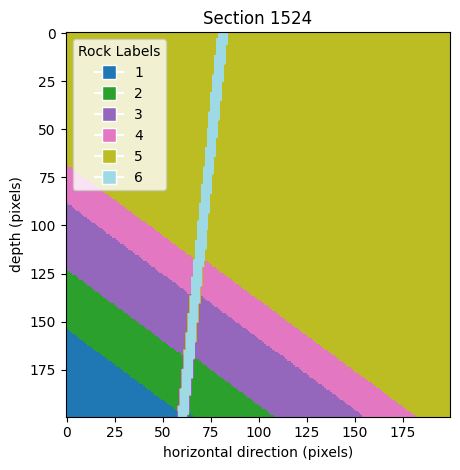

In [13]:
random_npz: int = random_gen.integers(0, nbr_npz - 1, 1)[0]
multi_array: np.ndarray[np.int8] = np.load(dataset_path / f"{random_npz}.npz")["arr_0"]
print(f"Selected file {random_npz}.npz")
section_id: int = random_gen.choice(multi_array.shape[0], 1)[0]
print(f"Selected section {section_id}")
section: np.ndarray[np.int8] = multi_array[section_id]

fig, ax = plt.subplots(1, 1)
class_color_map, norm, cmap_custom = create_colorbar(section)
sub_plot(ax, 0, section, f"Section {section_id}", class_color_map, cmap_custom, norm)
plt.tight_layout()
plt.show()

## Select a random number of electrode and a random pixel length
We want 2 pixels between each electrodes so we want $ \left(n_{electrodes} - 1\right) \times 2 $ pixels.

In [14]:
nbr_electrodes: int = random_gen.integers(24, 96, 1)[0]
print(f"{nbr_electrodes} electrodes")
pixel_length: np.float64 = random_gen.integers(1, 20, 1)[0] / 2
print(f"Pixel length: {pixel_length} m")
total_true_length: np.float64 = nbr_electrodes * pixel_length
print(f"Total true length: {total_true_length} m")
total_pixels_to_keep: int = (nbr_electrodes - 1) * 2
print(f"Total pixels to keep: {total_pixels_to_keep}")

94 electrodes
Pixel length: 8.5 m
Total true length: 799.0 m
Total pixels to keep: 186


We keep half of the horizontal length vertical pixels.

Sample shape: (93, 186)


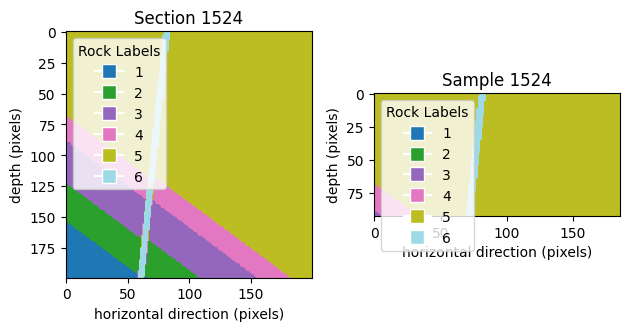

In [15]:
sample: np.ndarray[np.int8] = section[:total_pixels_to_keep // 2, :total_pixels_to_keep]
print(f"Sample shape: {sample.shape}")

fig, axes = plt.subplots(1, 2)
class_color_map, norm, cmap_custom = create_colorbar(section)
for idx, img in enumerate([section, sample]):
    sub_plot(axes, idx, img, f"Section {section_id}" if idx == 0 else f"Sample {section_id}", class_color_map, cmap_custom, norm)
plt.tight_layout()
plt.show()

## Resistivity assignation
We assign each rock class a random resistivity. The resistivity value is sampled from a uniform distribution on $ \left[0, 1\right] $ and mapped using a logarithm function to $ \left[2, 20000\right] $.

In [16]:
rock_classes: np.ndarray[np.int8] = np.unique(sample)
sample_log_res: np.ndarray[np.float64] = sample.astype(np.float64)
for rock_class in rock_classes:
    random_log_resistivity: np.float64 = random_gen.uniform(0, 1)
    print(f"Rock class {rock_class} with log resistivity {random_log_resistivity} (true resistivity is {detransform(random_log_resistivity)} ohm.m)")
    sample_log_res[sample == rock_class] = random_log_resistivity

Rock class 3 with log resistivity 0.6510357372456165 (true resistivity is 803.8461658886572 ohm.m)
Rock class 4 with log resistivity 0.1252742337820696 (true resistivity is 6.340549987675096 ohm.m)
Rock class 5 with log resistivity 0.6225604029037661 (true resistivity is 618.4030277835103 ohm.m)
Rock class 6 with log resistivity 0.4880194392818582 (true resistivity is 179.10501763203536 ohm.m)


Visualization:

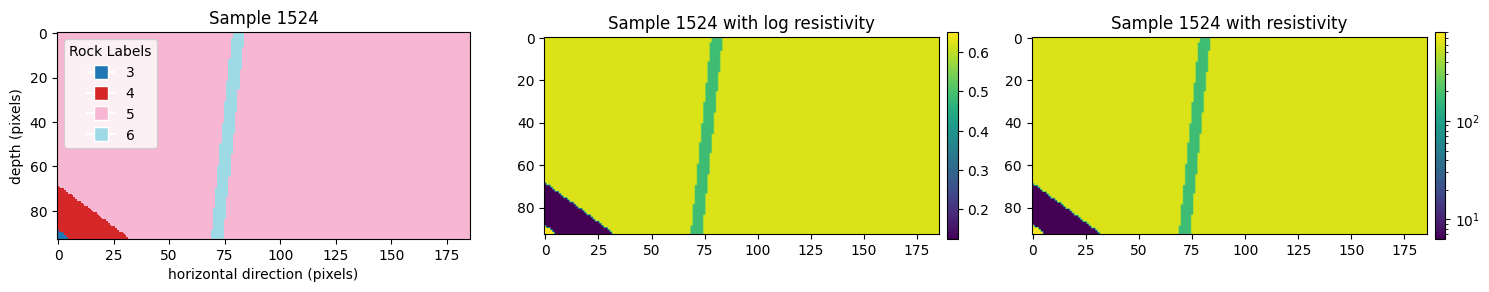

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

class_color_map, norm, cmap_custom = create_colorbar(sample)
sub_plot(axes, 0, sample, f"Sample {section_id}", class_color_map, cmap_custom, norm)
img = axes[1].imshow(sample_log_res, cmap="viridis")
axes[1].set_title(f"Sample {section_id} with log resistivity")
fig.colorbar(img, ax=axes[1], orientation='vertical', fraction=0.025, pad=0.02)
img = axes[2].imshow(detransform(sample_log_res), cmap="viridis", norm=mcolors.LogNorm())
axes[2].set_title(f"Sample {section_id} with resistivity")
fig.colorbar(img, ax=axes[2], orientation='vertical', fraction=0.025, pad=0.02)
plt.tight_layout()
plt.show()

## pyGIMLi processing
First we create a grid with the same shape as the numpy array section. As the grid is described by its nodes but the numpy array is by its pixels, we need to have a grid that is total_pixels_to_keep + 1 large (number of pixels + the most right node).

(93, 186)


(<Axes: xlabel='$x$ in m', ylabel='Depth in m'>,
 <matplotlib.colorbar.Colorbar at 0x163b3d33c50>)

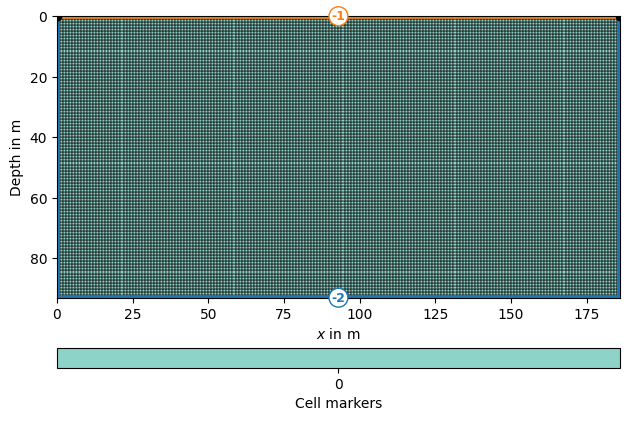

In [18]:
print(sample.shape)
x_arr: np.ndarray[np.float64] = np.linspace(0., total_pixels_to_keep, total_pixels_to_keep + 1, dtype=np.float64)
y_arr: np.ndarray[np.float64] = np.linspace(-(total_pixels_to_keep // 2), 0, total_pixels_to_keep // 2 + 1, dtype=np.float64)
world: pg.core.Mesh = pg.createGrid(x=x_arr, y=y_arr, worldBoundaryMarker=True)
pg.show(world, showMesh=True, markers=True)

Then, we place the electrodes on the nodes.

The schemes are the following:

Wenner Alpha (C-P-P-C) :  wa

Wenner Beta(C-C-P-P) :  wb

Dipole Dipole (CC-PP) :  dd

Schlumberger(C-PP-C) :  slm

Pole Pole (C-P) :  pp

Pole Dipole (C-PP) :  pd

Half Wenner (C-P-P) :  hw

MultipleGradient(C--P-P--C) :  gr

Warning! DataSchemeBase::create has unhandled arguments
{'spacing': np.float64(8.5)}
Warning! DataSchemeBase::create has unhandled arguments
{'spacing': np.float64(8.5)}


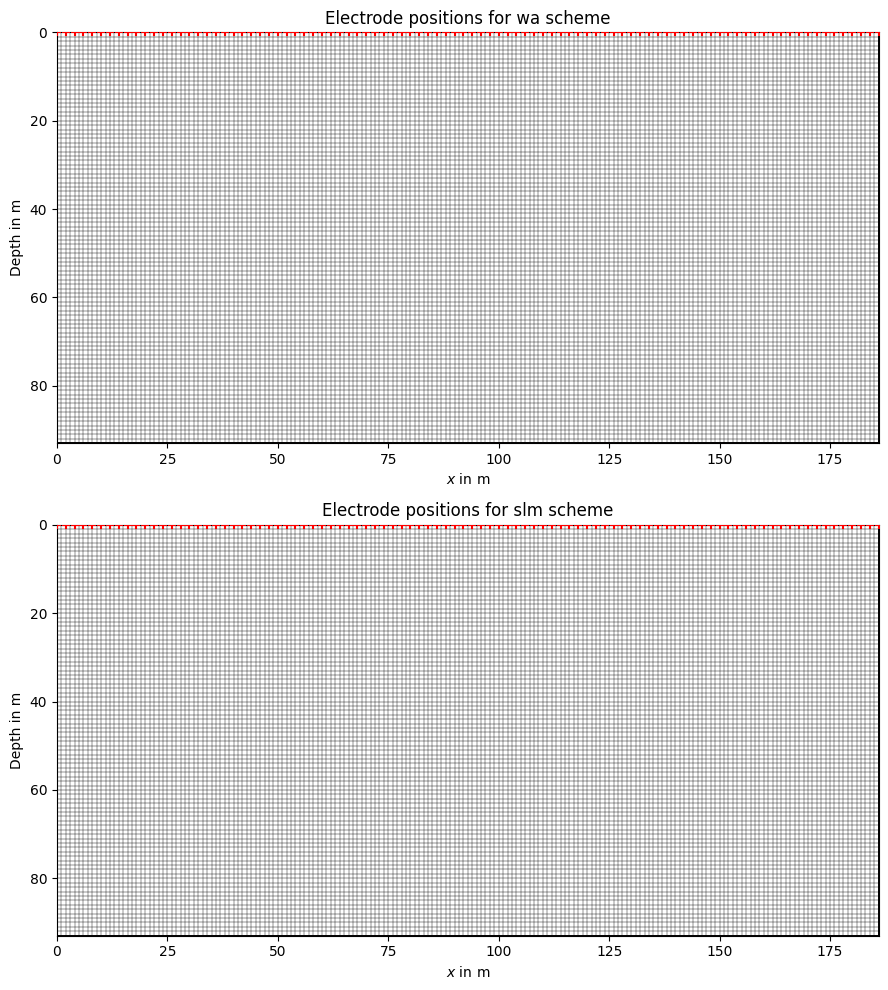

In [19]:

# scheme_names: list[str] = ["wa", "wb", "dd", "slm", "pp", "pd", "hw", "gr"]
scheme_names: list[str] = ["wa", "slm"]

elec_array: np.float64 = np.linspace(0., total_pixels_to_keep, nbr_electrodes, dtype=np.float64)  # np.float64 to be compatible with C++ double
schemes: dict[str, pg.DataContainerERT] = {scheme_name: ert.createData(elecs=elec_array, schemeName=scheme_name, spacing=pixel_length) for scheme_name in scheme_names}

fig, axes = plt.subplots(len(scheme_names), 1, figsize=(10, 10))
for idx, (key, scheme) in enumerate(schemes.items()):
    pg.show(world, ax=axes[idx], showMesh=True)
    electrode_positions: np.ndarray[np.float64] = np.array([scheme.sensorPosition(i) for i in range(scheme.sensorCount())])
    axes[idx].scatter(electrode_positions[:, 0], electrode_positions[:, 1], marker='+', color='red', label='Electrodes', zorder=3)
    axes[idx].set_title(f"Electrode positions for {key} scheme")
plt.tight_layout()
plt.show()

This is the forward modelling step.

In [20]:
sample_res: np.ndarray[np.float64] = detransform(sample_log_res)
print(sample_res.ravel().shape)
print(world.cellCount())
results: dict[str, pg.DataContainerERT] = {electrode_scheme_name: ert.simulate(world, res=sample_res.ravel(), scheme=scheme, verbose=True) for electrode_scheme_name, scheme in schemes.items()}

(17298,)
17298


And the pseudosection can be viewed using:

Pseudo-section for wa scheme


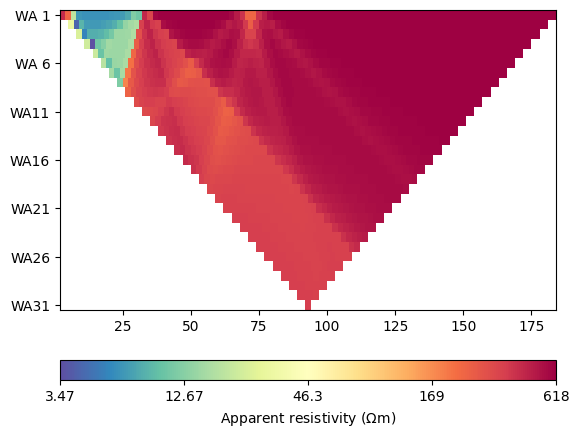

Pseudo-section for slm scheme


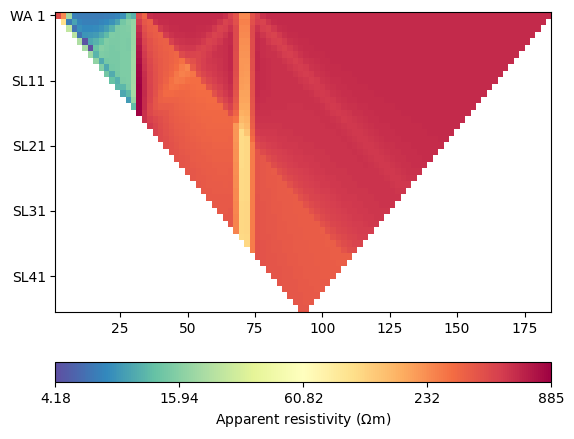

In [21]:
for scheme_name, result in results.items():
    print(f"Pseudo-section for {scheme_name} scheme")
    ert.showERTData(result)
    plt.show()

To recreate the pseudo-section for wenner array, we have to use this code (a interpolation is done at the middle, 1 line out of 2)

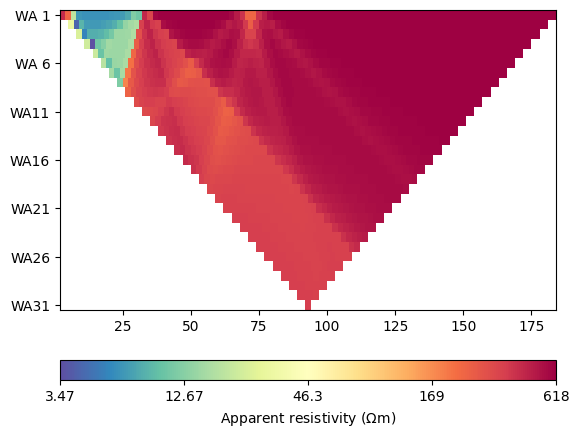

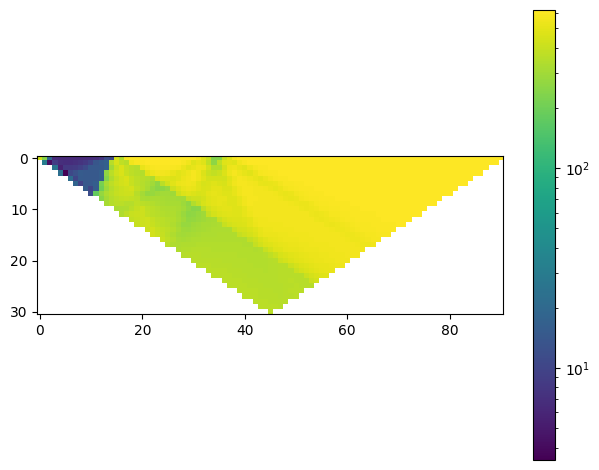

In [22]:
result_wenner_array: pg.DataContainerERT = results["wa"]
ert.showERTData(result_wenner_array)
plt.show()

rhoa: list[float] = result_wenner_array["rhoa"]
num_values: int = len(rhoa)

num_rows: int = (nbr_electrodes - 1) // 3
num_cols: int = nbr_electrodes - 3

even_num_cols: bool = (num_cols % 2 == 0)
if even_num_cols:
    num_cols += 1

offset: int = (nbr_electrodes - 1) % 2

result: np.ndarray[np.float64] = np.zeros((num_rows, num_cols), dtype=np.float64)
value_index: int = 0

for i in range(num_rows):
    # Determine if the current row is considered "even" based on num_cols parity
    is_even_row = (i % 2 == 0) if even_num_cols else (i % 2 == 1)
    
    col_start, col_end = compute_active_columns(i, is_even_row, num_cols, offset)
    
    for j in range(col_start, col_end):
        # For even rows, use a special average at the center column
        if is_even_row and j == (num_cols - 1) // 2:
            result[i, j] = (rhoa[value_index - 1] + rhoa[value_index]) / 2
        else:
            result[i, j] = rhoa[value_index]
            value_index += 1

plt.imshow(result, cmap="viridis", norm=mcolors.LogNorm())
plt.colorbar()
plt.tight_layout()
plt.show()

For schlumberger array, process is easier (be careful there is a printing bug in pyGIMLi for schlumberger scheme: the last column of each line is duplicated):

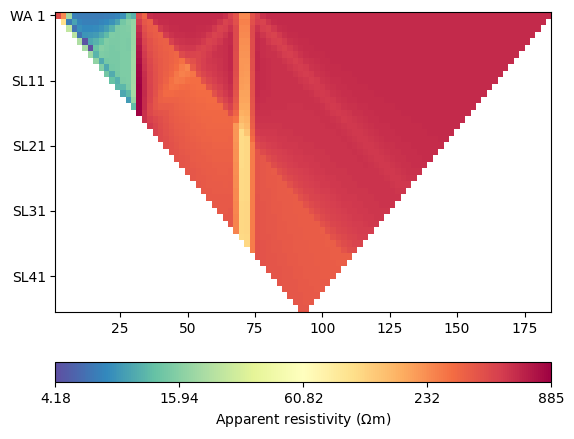

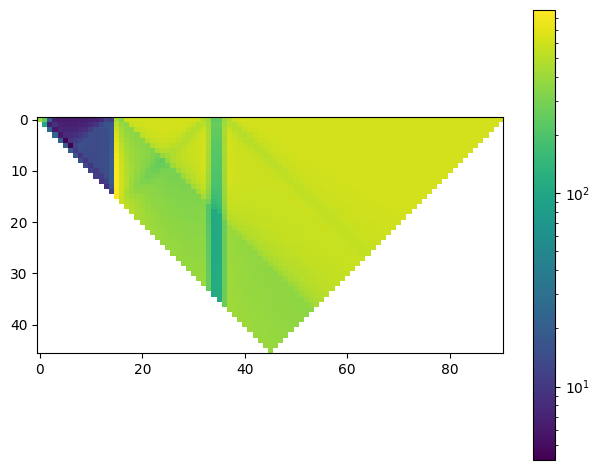

In [23]:
result_schlumberger_array: pg.DataContainerERT = results["slm"]
ert.showERTData(result_schlumberger_array)
plt.show()

# Get the data and print the number of elements
rhoa: list[float] = result_schlumberger_array["rhoa"]
num_values: int = len(rhoa)

num_cols: int = nbr_electrodes - 3
num_lines: int = nbr_electrodes // 2 - 1

result: np.ndarray[np.float64] = np.zeros((num_lines, num_cols), dtype=np.float64)

value_index: int = 0
for i in range(num_lines):
    start_col: int = i
    end_col: int = num_cols - i
    num_values_this_row: int = end_col - start_col
    result[i, start_col:end_col] = rhoa[value_index : value_index + num_values_this_row]
    value_index += num_values_this_row

plt.imshow(result, cmap="viridis", norm=mcolors.LogNorm())
plt.colorbar()
plt.tight_layout()
plt.show()

We can see what inversion is giving:

In [24]:
for electrode_scheme_name, scheme in schemes.items():
    results[electrode_scheme_name]["err"] = 0.001 * results[electrode_scheme_name]["rhoa"]
    pg.info('Filtered rhoa (min/max)', min(scheme['rhoa']), max(scheme['rhoa']))
mgr: dict[str, ert.ERTManager] = {electrode_scheme_name: ert.ERTManager(scheme) for electrode_scheme_name, scheme in results.items()}
inv: dict[str, pg.RVector] = {electrode_scheme_name: mgr[electrode_scheme_name].invert(lam=20, verbose=True, mesh=world) for electrode_scheme_name in mgr.keys()}

27/02/25 - 09:15:33 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.0 0.0
27/02/25 - 09:15:33 - pyGIMLi - INFO - Filtered rhoa (min/max) 0.0 0.0
27/02/25 - 09:15:34 - pyGIMLi - INFO - Found 1 regions.
27/02/25 - 09:15:34 - pyGIMLi - INFO - Creating forward mesh from region infos.
27/02/25 - 09:15:34 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/02/25 - 09:15:35 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 50403 Cells: 49928 Boundaries: 50402
27/02/25 - 09:15:35 - pyGIMLi - INFO - Use median(data values)=6363.666590001284
27/02/25 - 09:15:35 - pyGIMLi - INFO - Created startmodel from forward operator:12482, min/max=6363.666590/6363.666590
27/02/25 - 09:15:35 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002C90BF50C70>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation: Logarithmic transform
min/max (data): 4588/6524
min/max (error): 459%/652%
min/max (start model): 6364/6364
--------------------------------------------------------------------------------


27/02/25 - 09:16:53 - pyGIMLi - INFO - Found 1 regions.
27/02/25 - 09:16:53 - pyGIMLi - INFO - Creating forward mesh from region infos.


inv.iter 0 ... chi² =    0.00
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    0.00 (dPhi = 25.25%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.00)                   #
################################################################################


27/02/25 - 09:16:53 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
27/02/25 - 09:16:53 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 50403 Cells: 49928 Boundaries: 50402
27/02/25 - 09:16:54 - pyGIMLi - INFO - Use median(data values)=6335.206549437778
27/02/25 - 09:16:54 - pyGIMLi - INFO - Created startmodel from forward operator:12482, min/max=6335.206549/6335.206549
27/02/25 - 09:16:54 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000002C8F2883CE0>
Data transformation: Logarithmic LU transform, lower bound 0.0, upper bound 0.0
Model transformation: Logarithmic transform
min/max (data): 4349/6524
min/max (error): 435%/652%
min/max (start model): 6335/6335
--------------------------------------------------------------------------------
inv.iter 0 ... chi² =    0.00
--------------------------------------------------------------------------------
inv.iter 1 ... chi² =    0.00 (dPhi = 28.01%) lam: 20.0


################################################################################
#                  Abort criterion reached: chi² <= 1 (0.00)                   #
################################################################################


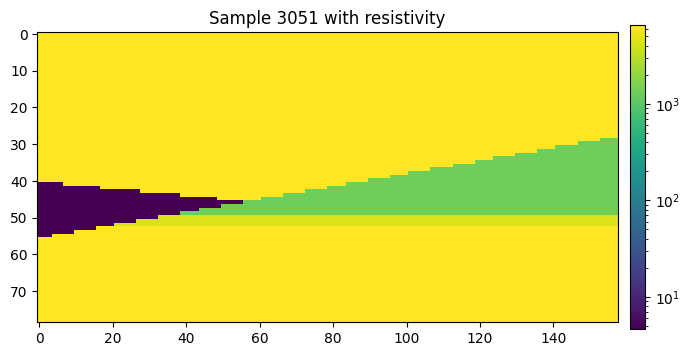

Inversion result for wa scheme


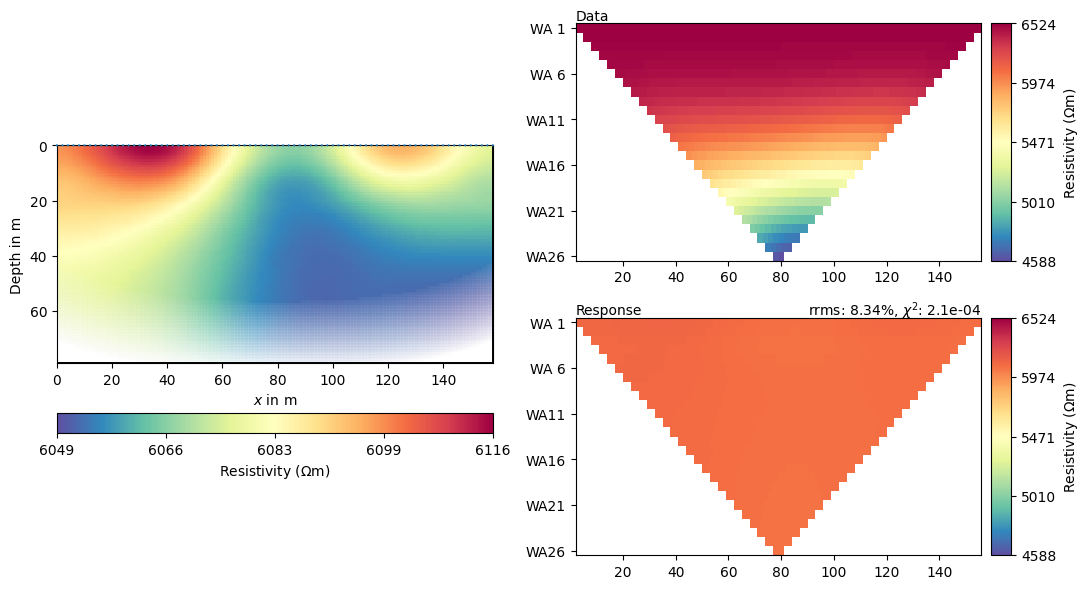

Inversion result for slm scheme


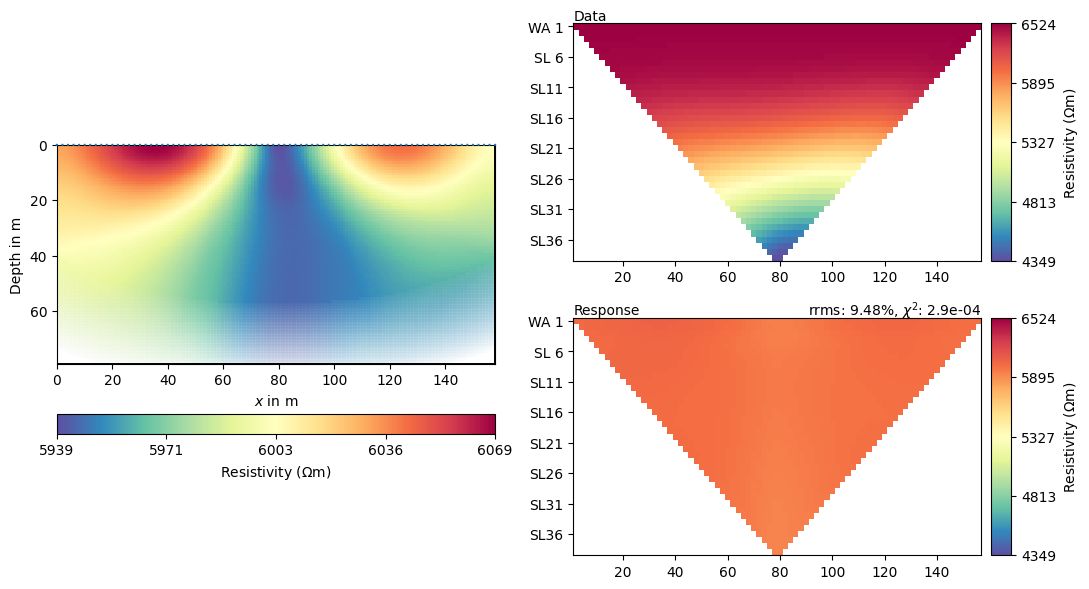

In [23]:
fig, ax = plt.subplots(figsize=(7, 5))
img = ax.imshow(detransform(sample_log_res)[::-1], cmap="viridis", norm=mcolors.LogNorm())
ax.set_title(f"Sample {section_id} with resistivity")
fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.025, pad=0.02)
plt.tight_layout()
plt.show()
for electrode_scheme_name, result in mgr.items():
    print(f"Inversion result for {electrode_scheme_name} scheme")
    result.showResultAndFit()
    plt.show()